# Satge M1 ingénierie mathématique pour la science des données: 

# Implémentation en Python des algorithmes 1 et 2 de l'article "Tensor moments of Gaussian mixture models: theory and applications" (Pereira, Kileel, Kolda, 2022), avec une méthode de descente de gradient

Soit $x_1,\ldots,x_p$ un ensemble de points à $n$ variables suivant un modèle de $m$ mélange gaussien $\mathcal{N}(\lambda,\mu,\Sigma)$, tel que $\lambda=(\lambda_1, \ldots,\lambda_m)$, les $\lambda_i$ sont les proportions de chaque distribution gaussienne dans le mélange ($\sum_{i=1}^m{\lambda_i}=1$), $\mu:=[\mu_1,\ldots,\mu_m]$ et $\Sigma:=[\Sigma_1,\ldots,\Sigma_m]$ tel que $(\mu_i,\Sigma_i)$ est la moyenne et la covariance du ième mélange pour $i\in\left\{1,\ldots,m\right\}$. On note par $\theta:=(\lambda,\mu,\Sigma)$.

Le problème d'identification de mélange gaussien cherche à trouver le paramètre latent $\theta$.

Le but de ce stage est d'utiliser des techniques tensorielles pour le problème d'identification des mélanges gaussiens. Le papier [Tensor moments of Gaussian mixture models: theory and applications](https://arxiv.org/pdf/2202.06930.pdf) est un article récent sur ce sujet, où ce problème est présenté sous forme d'un problème d'optimisation qui cherche à minimiser l'erreur entre le moment théorique d'ordre $d$ et le moment empirique d'ordre $d$ du modèle. D'après ce papier, la fonction de coût à minimiser, notée $F$, peut s'écrire sous la forme :
$$F=F_1-\frac{2}{p}F_2.$$

Dans ce notebook :
- Nous implémentons l'algorithme 1 (resp. algorithme 2) de cet article qui calcule les gradients de $F_1$ (resp. $F_2$) par rapport aux paramètres recherchés pour le cas sphérique ou isotropique (c'est-à-dire $\Sigma_i=\sigma_i^2I$).
- Nous donnons un exemple simple d'un ensemble de points générés suivant un mélange de trois gaussiennes sphériques.
- Nous implémentons, avec les gradients de $F_1$, une méthode de descente de gradient pour minimiser cette fonction avec $d=1, 2, 3$ et nous montrons les courbes décroissantes associées.
- Les gradients de $F$ sont déduits directement des gradients de $F_1$ et $F_2$. Avec les gradients de $F$, nous implémentons une méthode de descente de gradient pour minimiser $F$ pour $d=1, 2, 3$ et nous montrons ses courbes.

On note que le calcul des gradients de $F_1$ et $F_2$ présenté dans cet article est efficace, où le calcul des moments, qui constitue l'étape la plus coûteuse dans cette approche tensorielle, est effectué de manière implicite et efficiente.

# Code des fonctions $F_1$ et $F_2$ 

In [1]:
import numpy as np
from math import comb
import matplotlib.pyplot as plt
import numpy.linalg as LA

# one_zero(k) renvoie 1 si k>1 sinon renvoie 0

def one_zero(k):
    if k>1:
        return 1
    else:
        return 0
    
# two_zero(k) renvoie 1 si k>2 sinon renvoie 0

def two_zero(k):
    if k>2:
        return 1
    else:
        return 0
    

def ph(A, k):
  #entrée tenseur et un entier
  #Retour la produit d'hadamard de A k fois 
    n = A.shape[0]
    m = A.shape[1]
    res = A.copy()
    for i in range(k-1):
        res = np.multiply(res, A)

    return res

def F1(theta, d):
    lamb, A, D = theta
    m = A.shape[1]
    Bs = [np.ones((m,m))]
    Ks = []
    for k in range(1, d+1):
        Kk = np.zeros((m, m))
        km1_fact = np.math.factorial(k-1)
        if k%2 == 1:
            Kk = np.math.factorial(k)*(np.transpose(np.multiply(ph(D,k-1), A)))@(np.multiply(ph(D,k-1), A))
        else:
            V = (np.transpose(ph(D,k)))@(np.multiply(ph(D,k-2), ph(A,2)))
            Kk = np.math.factorial(k-1)*(np.transpose(ph(D,k))@ph(D,k)) + (np.math.factorial(k)/2)*(V+np.transpose(V))
        Ks.append(Kk)
        Bk = np.zeros((m,m))
        for r in range(0, k):
            Bk = Bk + comb(k-1, r)*(np.multiply(Bs[r], Ks[k-r-1]))
        Bs.append(Bk)
    f = lamb@(Bs[d])@np.transpose(lamb)
    W_lamb = 2*lamb@Bs[d]
    W_A = 0
    W_D = 0
    for k in range(1, d+1):
        B = np.multiply(Bs[d-k], np.transpose(lamb)@lamb)
        k_fact = np.math.factorial(k)
        if k%2 == 1:
            T_D = np.math.factorial(k)*np.multiply(ph(D,k-1), A)
            U_D = one_zero(k)*(k-1)*np.multiply(ph(D,k-2), A)
            W_D = W_D + 2*comb(d, k)*np.multiply(T_D@B, U_D)
            T_A = np.math.factorial(k)*np.multiply(ph(D,k-1), A)
            U_A = ph(D,k-1)
            W_A = W_A + 2*comb(d, k)*np.multiply(T_A@B, U_A)
        else:
            T_D1 = np.math.factorial(k)*ph(D,k) + k*(np.math.factorial(k)/2)*(np.multiply(ph(D,k-2), ph(A,2)))
            U_D1 = ph(D,k-1)
            T_D2 = (np.math.factorial(k)/2)*ph(D,k)
            U_D2 = two_zero(k)*(k-2)*(np.multiply(ph(D,k-3), ph(A,2)))
            W_D = W_D + 2*comb(d,k)*(np.multiply(T_D1@B, U_D1) + np.multiply(T_D2@B, U_D2))
            T_A = np.math.factorial(k)*ph(D,k)
            U_A = np.multiply(ph(D,k-2), A)
            W_A = W_A + 2*comb(d, k)*(np.multiply(T_A@B, U_A))
    return (f,W_A,W_D,W_lamb)
        
    

def F2(X,theta,d):
    lamb, A, D = theta
    p = X.shape[1]
    m = lamb.shape[1] #la matrice lamb est en ligne
    n = A.shape[0]
    V = np.transpose(X)@A
    Z = ph((np.transpose(X)),2)@ph(D,2)
    if d == 1:
        R2 = np.zeros((p,m))
        R1 = np.ones((p,m))
    else:
        R2 = np.ones((p,m))
        R1 = V
    R2_copy = R2.copy()
    R1_copy = R1.copy()
    for k in range(2,d):
        R3 = R2_copy
        R2 = R1_copy
        R1 = np.multiply(R2,V)+(k-1)*np.multiply(R3,Z)
        R3_copy = R3.copy()
        R2_copy = R2.copy()
        R1_copy = R1.copy()
    T = X@R1
    W_A = d*T@np.diag(lamb[0,:])
    U = (d-1)*np.multiply((ph(X,2)@R2),D)
    W_D = d*U@np.diag(lamb[0,:])
    W_lamb = (np.multiply(T,A)+np.multiply(U,D))[0]
    f = W_lamb @ np.transpose(lamb)
    
    return (f,W_A,W_D,W_lamb)

La fonction 'samples' génère des points suivant une distribution de mélange gaussien.

In [4]:
def generate_gaussian_mixture_samples(p, means, covs, weights):
    num_components = len(means)
    samples = np.zeros((p, 2))
    components = np.random.choice(num_components, size=p, p=weights)
    y = []
    for i, c in enumerate(components):
        samples[i] = np.random.multivariate_normal(means[c], covs[c])
        y.append(c)
    return samples,y


Voici un exemple des points générés suivant un mélange de trois gaussiennes sphériques.

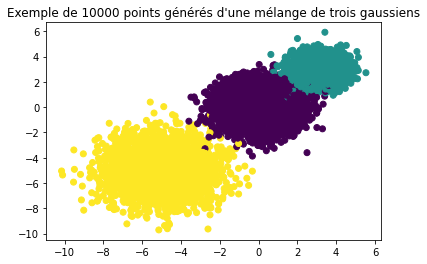

In [340]:
# Définition des paramètres du modèle de mélange gaussien
means = np.array([[0, 0], [3, 3], [-5, -5]])
covs = np.array([[[1, 0], [0, 1]], [[0.5, 0.0], [0.0, 0.5]], [[2, 0.0], [0.0, 2]]])
weights = np.array([0.5, 0.2, 0.3])

# Générer un dataset de 100 points
p = 10000
samples,y = generate_gaussian_mixture_samples(p, means, covs, weights)

# Afficher les samples
plt.scatter(samples[:, 0], samples[:, 1],c=np.array(y))
plt.title("Exemple de 10000 points générés d'une mélange de trois gaussiens")
plt.show()

On ajoute une perturbation d'ordre 1e-3 au paramètre $\theta$. Ce point sera utilisé comme point initial pour les itérations de descente de gradient..

In [384]:
lamb = np.array([[0.5,0.2,0.3]])
mu_1 = np.array([0,0])
mu_2 = np.array([3,3])
mu_3 = np.array([-5,-5])
A = np.array([mu_1,mu_2,mu_3])
Abis=A.T # je transpose pour que ça colle à l'algorithme
D = np.array([[1,1],[np.sqrt(0.5),np.sqrt(0.5)],[np.sqrt(2),np.sqrt(2)]]) #D'après l'article D est de taille nxm d'où pourquoi j'ai mis en vecteur 
Dbis = D.T # je transpose pour que ça colle à l'algorithme
per1=np.random.randn(1,3)
per2=np.random.randn(2,3)
per3=np.random.randn(2,3)
lamb_0 = lamb+10**(-3)*(per1/LA.norm(per1))
Abis_0 = Abis+10**(-3)*(per2/LA.norm(per2))
Dbis_0 = Dbis+10**(-3)*(per3/LA.norm(per3))
theta=(lamb_0,Abis_0,Dbis_0)

Appliquer la méthode de descente de gradient pour minimiser $F_1$ pour $d=1$.

In [343]:
f_1=[]
d=2
m=3
for i in range(80):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,1)
    f_1.append(f1[0][0])
    #print(f1[0][0])
    lamb = lamb-0.001*W_lamb1
    #print(lamb)
    Dbis = Dbis-0.001*W_D1
    Abis = Abis-0.001*W_A1
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = ((np.sum(lamb))**(1/3))*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)

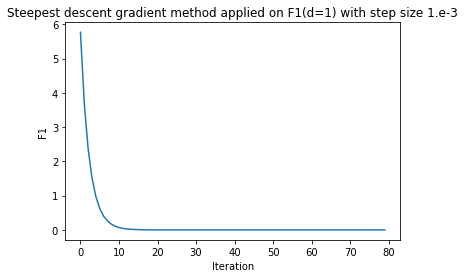

In [338]:
plt.plot(np.array(f_1))
plt.xlabel("Iteration")
plt.ylabel("F1")
plt.title("Steepest descent gradient method applied on F1(d=1) with step size 1.e-3")
plt.show()

Appliquer la méthode de descente de gradient pour minimiser $F_1$ pour $d=2$.

In [321]:
f_1=[]
d=2
m=3
for i in range(50000):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,2)
    f_1.append(f1[0][0])
    #print(f1[0][0])
    lamb = lamb-0.0001*W_lamb1
    #print(lamb)
    Dbis = Dbis-0.0001*W_D1
    Abis = Abis-0.0001*W_A1
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = ((np.sum(lamb))**(1/3))*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)

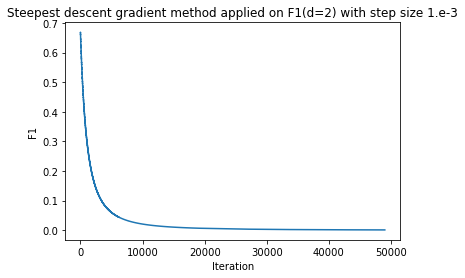

In [323]:
plt.plot(np.array(f_1[1000:]))
plt.xlabel("Iteration")
plt.ylabel("F1")
plt.title("Steepest descent gradient method applied on F1(d=2) with step size 1.e-4")
plt.show()

Appliquer la méthode de descente de gradient pour minimiser $F_1$ pour $d=3$.

In [385]:
f_1=[]
d=3
m=3
for i in range(50000):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,3)
    f_1.append(f1[0][0])
    #print(f1[0][0])
    lamb = lamb-0.0000001*W_lamb1
    #print(lamb)
    Dbis = Dbis-0.0000001*W_D1
    Abis = Abis-0.0000001*W_A1
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = ((np.sum(lamb))**(1/3))*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)

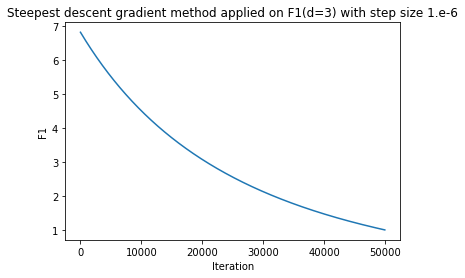

In [389]:
plt.plot(np.array(f_1[100:]))
plt.xlabel("Iteration")
plt.ylabel("F1")
plt.title("Steepest descent gradient method applied on F1(d=3) with step size 1.e-6")
plt.show()

Appliquer la méthode de descente de gradient pour minimiser $F$ pour $d=1$.

In [360]:
f=[]
d=1
m=3
p=10000
theta_list=[]
for i in range(1000):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,1)
    f2,W_A2,W_D2,W_lamb2 = F2(samples.T,theta,1)
    lamb = lamb-0.00001*(W_lamb1-2/p*W_lamb2)
    Dbis = Dbis-0.00001*(W_D1-2/p*W_D2)
    Abis = Abis-0.00001*(W_A1-2/p*W_A2)
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = np.sum(lamb)*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)
    a=f1[0][0]-1/p*f2[0]
    #print(a)
    if a>0:
        f.append(f1[0][0]-2/p*f2[0])

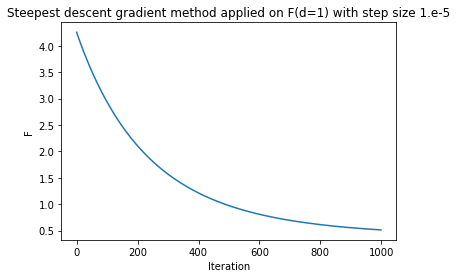

In [361]:
#plt.figure(figsize=(20,5))
plt.plot(np.array(f))
plt.xlabel("Iteration")
plt.ylabel("F")
plt.title("Steepest descent gradient method applied on F(d=1) with step size 1.e-5")
plt.show()

Appliquer la méthode de descente de gradient pour minimiser $F$ pour $d=2$.

In [368]:
f=[]
d=2
m=3
p=10000
theta_list=[]
for i in range(10000):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,2)
    f2,W_A2,W_D2,W_lamb2 = F2(samples.T,theta,2)
    lamb = lamb-0.0000001*(W_lamb1-2/p*W_lamb2)
    Dbis = Dbis-0.0000001*(W_D1-2/p*W_D2)
    Abis = Abis-0.0000001*(W_A1-2/p*W_A2)
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = np.sum(lamb)*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)
    a=f1[0][0]-1/p*f2[0]
    #print(a)
    if a>0:
        f.append(a)
    

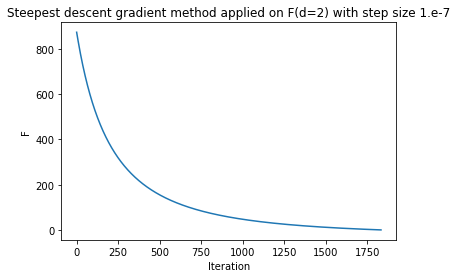

In [369]:
plt.plot(np.array(f))
plt.xlabel("Iteration")
plt.ylabel("F")
plt.title("Steepest descent gradient method applied on F(d=2) with step size 1.e-7")
plt.show()

Appliquer la méthode de descente de gradient pour minimiser $F$ pour $d=3$.

In [373]:
f=[]
d=3
m=3
p=10000
theta_list=[]
for i in range(50000):
    f1,W_A1,W_D1,W_lamb1 = F1(theta,3)
    f2,W_A2,W_D2,W_lamb2 = F2(samples.T,theta,3)
    lamb = lamb-0.000000001*(W_lamb1-2/p*W_lamb2)
    Dbis = Dbis-0.000000001*(W_D1-2/p*W_D2)
    Abis = Abis-0.000000001*(W_A1-2/p*W_A2)
    for j in range(m):
        if lamb[0,j]<0:
            lamb[0,j]=-lamb[0,j]
            Abis[:,j] = -Abis[:,j]
    for j in range(m):
        Abis[:,j] = np.sum(lamb)*Abis[:,j]
    lamb=lamb/np.sum(lamb)
    theta = (lamb,Abis,Dbis)
    a=f1[0][0]-1/p*f2[0]
    if a>0:
        f.append(a)
    

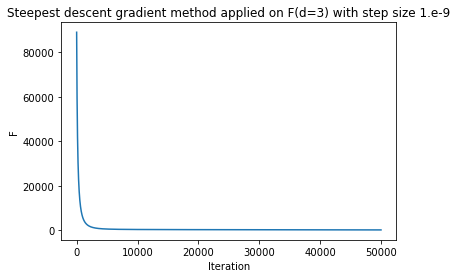

In [374]:
plt.plot(np.array(f))
plt.xlabel("Iteration")
plt.ylabel("F")
plt.title("Steepest descent gradient method applied on F(d=3) with step size 1.e-9")
plt.show()

L'implémentation de la méthode de descente de gradient montre que la fonction $F$ décroît. Ainsi, si on compare le résultat obtenu avec les résultats réels, on constate qu'il est proche à un scalaire près. En réalité, cela est prévu, car la fonction $F$ peut donner des solutions à notre problème à un scalaire près. Néanmoins, comme discuté dans l'article, la solution consiste à utiliser une fonction dite augmentée au lieu de $F$ qui prend la somme des moments jusqu'à l'ordre $d$.